In [15]:
%pip install numpy
%pip install math3d
%pip install svgpathtools
%pip install urx
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import math3d as m3d
import math
import sys
import urx
from time import sleep
from svgpathtools import svg2paths, Arc, Line, QuadraticBezier, CubicBezier

In [5]:
np.set_printoptions(precision=3)
r = urx.Robot("192.168.1.3", use_rt=True)
r.set_tcp((0, 0, 0.15, 0, 0, 0))
r.set_payload(0.1)
sleep(0.2)

TimeoutError: timed out

In [6]:
a = 0.1 # Beschleunigung m/s^2
v = 0.2 #0.3 Geschwindigkeit m/s
hover = 0.02 # hover over canvas while not painting
feed = 0.001 # Pinsel-Vorschub in m/m, 0.003 fuer Baumarkt Pinsel
offset = 0.003 # Pinsel-Andruck in m (0.008 fuer Baumarkt Pinsel, 0.005 fuer Medium)

paint_depth = 0.100     # Eintauchtiefe ab Position über Farbe in m, 
in_paint_duration = 0.5 # Pinsel in der Farbe in s, fuer Baumarkt 0.5
drop_off_duration = 1   # 1 Abtropf-Phase in s, fuer Baumarkt 1

r.set_csys(m3d.Transform())

NameError: name 'r' is not defined

In [6]:
# Joint configurations:
# Make sure that a free path exists between any of those!
j_home         = ( 0    , -math.pi/2,  0, -math.pi/2, 0, 0)
j_paint_above  = (-1.257, -1.332, -2.315, -1.065, 1.571,  0.313)
j_canvas_above = (-0.671, -1.464, -1.975,  0.026, 2.302, -0.169)
j_brush_change = (0.0, -0.725, -2.153, -1.570, 0, 0)

In [42]:
# Canvas coordinates (base csys):
# p0 ---------> px
# |
# |
# py

# Tranform(vector, orientation) for old setting
#p0 = m3d.Transform(( 0.503,  0.237,  0.677, -1.497,  1.332, -1.134))
#px = m3d.Transform(( 0.501, -0.509,  0.669, -1.497,  1.332, -1.134))
#py = m3d.Transform(( 0.399,  0.242,  0.137, -1.497,  1.333, -1.134))

#small brushes
p0 = m3d.Transform(( 0.534,  0.230,  0.677, -1.497,  1.332, -1.134))
px = m3d.Transform(( 0.549, -0.509,  0.669, -1.497,  1.332, -1.134))
py = m3d.Transform(( 0.430,  0.230,  0.137, -1.497,  1.333, -1.134))

In [43]:
#r.movep(p0, vel=v)
#r.movep(px, vel=v)
#r.movep(py, vel=v)

cx = px.pos - p0.pos
cy = py.pos - p0.pos
canvas_coordinates = m3d.Transform.new_from_xyp(cx, cy, p0.pos)


In [9]:
# Paint pot coordinates:
paint = {"red":    (-0.12, -0.280, 0.08, 0, np.pi, 0),
         "yellow": (-0.04, -0.280, 0.08, 0, np.pi, 0),
         "blue":   ( 0.04, -0.280, 0.08, 0, np.pi, 0),
         "black":  ( 0.12, -0.285, 0.08, 0, np.pi, 0)}

In [10]:
# Paint drop removal coordinates:
mesh  = {"red":    m3d.Vector(-0.12, -0.40, 0.057),
         "yellow": m3d.Vector(-0.04, -0.40, 0.055),
         "blue":   m3d.Vector( 0.04, -0.40, 0.054),
         "black":  m3d.Vector( 0.12, -0.40, 0.053)}

In [11]:
# Brush calibration point
brush_calib_above = (-0.168, -0.315, 0.08, 0, np.pi, 0)
brush_calib_down  = (-0.168, -0.315, 0.027, 0, np.pi, 0)


In [12]:
def brush_transform(index, angle, length):
    rot = m3d.Orientation.new_rot_z(index * np.pi / 2)
    rot.rotate_x(angle)
    vec = m3d.Transform(rot, (0, 0, 0)) * m3d.Vector(0, 0, length)
    return m3d.Transform(rot, vec)

In [13]:
# Brush calibration parameters
# Old brush holder    
#brush = {"red":    brush_transform(-1, 24 * np.pi / 180, 0.148),
#         "yellow": brush_transform( 0, 19 * np.pi / 180, 0.145),
#         "blue":   brush_transform( 1, 20 * np.pi / 180, 0.145),
#         "black":  brush_transform( 2, 24 * np.pi / 180, 0.147)}
# New brush holder
#brush = {"red":    brush_transform(-1, 32 * np.pi / 180, 0.144),
#         "yellow": brush_transform( 0, 33 * np.pi / 180, 0.148),
#         "blue":   brush_transform( 1, 30 * np.pi / 180, 0.144),
#         "black":  brush_transform( 2, 31 * np.pi / 180, 0.144)}

# Medium size brush holder
#brush = {"red":    brush_transform(-1, 25 * np.pi / 180, 0.140),
#         "yellow": brush_transform( 0, 25 * np.pi / 180, 0.140),
#         "blue":   brush_transform( 1, 26 * np.pi / 180, 0.140),
#         "black":  brush_transform( 2, 25 * np.pi / 180, 0.140)}

# Small size brush holder
brush = {"red":    brush_transform(-0.935, 28.0 * np.pi / 180, 0.140),
         "yellow": brush_transform( 0.09, 27 * np.pi / 180, 0.138),
         "blue":   brush_transform( 1, 29 * np.pi / 180, 0.139),
         "black":  brush_transform( 2.1, 29 * np.pi / 180, 0.139)}
#%%

In [14]:
#p = r.getl()
#print "Start tool pose is: ", np.array(p)
#print "Joint space: ", np.array(r.getj()) * 180 / math.pi

#print "Move to home"
#r.movej(j_home, acc=1.0, vel=v)


In [ ]:
def move_home():
    print "Move to home"
    r.movej(j_home, acc=1.0, vel=v)

In [16]:
def move_to_canvas():
    print "Move to canvas"
    j = r.getj() # Keep orientation of last joint
    r.movej(j_canvas_above[:5] + (j[5],), acc=a, vel=v)

In [17]:
def move_to_paint():
    print "Move to paint"
    r.movej(j_paint_above, acc=a, vel=v)
    #j = r.getj() # Keep orientation of last joint
    #r.movej(j_paint_above[:5] + (j[5],), acc=a, vel=v)

In [18]:
def move_to_brush_change():
    print "Move to brush change"
    r.movej(j_brush_change, acc=a, vel=v)

In [19]:
def move_to_brush_calibration(stroke):
    print "Set base coordiante system"
    r.set_csys(m3d.Transform())

    print "Calibrate brush"
    #   Move with no brush selected to avoid extreme rotations of last joint
    r.set_tcp((0, 0, 0.15, 0, 0, 0))
    print "  Move over calibration point"
    r.movel(brush_calib_above, acc=a, vel=v)
    #   Select brush
    r.set_tcp(brush[stroke])
    r.movel(brush_calib_above, acc=a, vel=v)
    #   Move into color
    print "  Move to calibration point"
    r.movel(brush_calib_down, acc=a/2, vel=v/4)

In [20]:
def calibrate_brush(stroke):
    move_to_brush_calibration(stroke)
    raw_input("Measure brush length and press enter to continue...")
    r.movel(brush_calib_above, acc=a, vel=v)

In [21]:
def move_to_canvas_origin(stroke):
    print "Set canvas coordinate system"
    r.set_csys(canvas_coordinates)
    r.set_tcp(brush[stroke])
    r.movel((0, 0, -hover, 0, 0, 0), acc=a, vel=v)

In [22]:
def move_to_canvas_xaxis(stroke):
    print "Set canvas coordinate system"
    r.set_csys(canvas_coordinates)
    r.set_tcp(brush[stroke])
    r.movel((0.75, 0, -hover, 0, 0, 0), acc=a, vel=v)

In [23]:
def move_to_canvas_yaxis(stroke):
    print "Set canvas coordinate system"
    r.set_csys(canvas_coordinates)
    r.set_tcp(brush[stroke])
    r.movel((0, 0.55, -hover, 0, 0, 0), acc=a, vel=v)

In [24]:
def get_paint(stroke):
    print "Set base coordiante system"
    r.set_csys(m3d.Transform())

    # TODO: check current position
    print "  Distance to pots:", r._get_joints_dist(j_paint_above)

    print "Get new paint"
    #   Move with no brush selected to avoid extreme rotations of last joint
    r.set_tcp((0, 0, 0.15, 0, 0, 0))
    print "  Move over color pot"
    r.movel(paint[stroke], acc=a, vel=v)
    #   Measure color depth
    
    #   Select brush
    r.set_tcp(brush[stroke])
    r.movel(paint[stroke], acc=a, vel=v)
    #   Move into color
    print "  Move into color pot"
    r.down(z=paint_depth, acc=a/2, vel=v/3)
    sleep(in_paint_duration)

    print "  Move over color pot"
    r.movel(paint[stroke], acc=a, vel=v)
    print "  Wait for color to drop off"
    sleep(drop_off_duration)
    
    print "  Remove paint from tip of brush"
    radius = 0.018
    circle = [m3d.Transform(m3d.Orientation.new_rot_z(i * np.pi / 6), (0, 0, 0)) * m3d.Vector(-radius, -radius, 0) for i in range(8)]
    circle = [m3d.Transform((0, np.pi, 0), mesh[stroke] + c) for c in circle]
    circle.append(m3d.Transform(paint[stroke]))
    r.movels(circle, acc=a, vel=v/4)

In [52]:
def paint_path(path):
    print "Set canvas coordinate system"
    r.set_csys(canvas_coordinates)

    # TODO: check current position
    print "  Distance to canvas:", r._get_joints_dist(j_canvas_above)

    print "Paint path"
    for sub in path.continuous_subpaths():
        print "  Paint continuous sub path with length %smm" % (round(sub.length()))
        r.movel((sub.start.real / 1e3, sub.start.imag / 1e3, -hover, 0, 0, 0), acc=a, vel=v)
        poses = []
        acc_dist = 0
        for seg in sub:
            if isinstance(seg, Line):
                #print "    ", seg, "length:", seg.length()
                poses.append((seg.start.real / 1e3, seg.start.imag / 1e3, offset + feed * acc_dist / 1e3, 0, 0, 0))
                acc_dist += seg.length()
            elif isinstance(seg, Arc):
                print "TODO: Arc is beta"
                
                #print "TODO: Arc is not supported, Line is used"
                #poses.append((seg.start.real / 1e3, seg.start.imag / 1e3, offset + feed * acc_dist / 1e3, 0, 0, 0))
                #print seg
                
                step = min(10.0 / seg.length(), 0.5) # one point everz 10mm but at least two points
                points = [seg.point(t) for t in np.arange(0, 1, step)]
                poses.extend([(p.real / 1e3, p.imag / 1e3, offset + feed * acc_dist / 1e3, 0, 0, 0) for p in points])
                
                #This interactive demo might help you understand the concepts behind SVG arcs: http://codepen.io/lingtalfi/pen/yaLWJG (tested in chrome and firefox only, might not work in your browser)
                #print seg
                #print poses
                # TODO acc_dist should be incremented from point to point
                
            elif isinstance(seg, QuadraticBezier):
                print "TODO: QuadraticBezier is beta"
                step = min(10.0 / seg.length(), 0.5) # one point everz 10mm but at least two points
                points = [seg.point(t) for t in np.arange(0, 1, step)]
                poses.extend([(p.real / 1e3, p.imag / 1e3, offset + feed * acc_dist / 1e3, 0, 0, 0) for p in points])
                # TODO acc_dist should be incremented from point to point

            elif isinstance(seg, CubicBezier):
                print "TODO: CubicBezier is beta"
                step = min(10.0 / seg.length(), 0.5) # one point everz 10mm but at least two points
                points = [seg.point(t) for t in np.arange(0, 1, step)]
                poses.extend([(p.real / 1e3, p.imag / 1e3, offset + feed * acc_dist / 1e3, 0, 0, 0) for p in points])
                # TODO acc_dist should be incremented from point to point

        poses.append((sub.end.real / 1e3, sub.end.imag / 1e3, offset, 0, 0, 0))
        poses.append((sub.end.real / 1e3, sub.end.imag / 1e3, -hover, 0, 0, 0))
        r.movels(poses, acc=a, vel=v/4, threshold=0.001)
    # If we are on left side of canvas move to save position first
    r.movel((0.6, 0.3, -hover, 0, 0, 0), acc=a, vel=v)

In [26]:
def paint_svg(paths, attributes):
    i = 0
    for (path, attr) in zip(paths, attributes):
        stroke = attr['stroke']
        print "Path", i, "with color", stroke, "of length", round(path.length())

        move_to_paint()
        try:
            get_paint(stroke)
            move_to_canvas()
            paint_path(path)
        except Exception as e:
            print "ERROR:", e
            raw_input("Press enter to continue... ")
        #move_to_canvas()

        i += 1

In [ ]:
# This would be the full program

try:
    move_home()
    paths, attributes = svg2paths('190905 JoPostmandarkblue.svg') #painting to paint       
    #paths, attributes = svg2paths(sys.argv[1])
    paint_svg(paths, attributes)
except Exception as e:
    print "ERROR:", e
    raw_input("Press enter to continue... ")
    

move_to_canvas()
move_home()

#%%

#r.stopj()
#p = r.getl()
#print "Tool pose is: ", np.array(p)
#print "Robot joints: ", r.getj()

#    r.secmon.close()
#    r.rtmon.close()
#    r = None
#    sleep(2)

Move to home
ERROR: 'stroke'


In [49]:
# Room for trying something out and calibrating 
# If you start the script please run all blocks from above until here


move_home()

#move_to_paint()
#move_to_brush_calibration("red") # "red", "yellow", "blue", "black"
#move_to_brush_calibration("yellow")
#move_to_brush_calibration("blue")
#move_to_brush_calibration("black")

#move_home()

#move_to_canvas()
#move_to_canvas_origin("red")
#move_to_canvas_xaxis("red")
#move_to_canvas_yaxis("red")
#attention!! dont directly do move_to_canvas after these!! 
#move_to_canvas_origin("red")
#move_home()






Move to home


In [16]:
#interactive calibration tool
#examplecode https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/

from ipywidgets import *
from IPython.display import display

currentBrush="black"

#print "Please calibrate only one brush at a time"
#print "Current brush:", currentBrush

#robot drives into home and then to brush calibration
move_home()
move_to_paint()
move_to_brush_calibration(currentBrush)


r0=-0.935
r1=28.0
r2=0.140

y0=0.09
y1=27
y2=0.138

blu0=1
blu1=29
blu2=0.139

bla0=2.1
bla1=29
bla2=0.139

def redefineBrush():
    global brush
    brush = {"red":    brush_transform(r0, r1 * np.pi / 180, r2),
         "yellow": brush_transform( y0, y1 * np.pi / 180, y2),
         "blue":   brush_transform( blu0, blu1 * np.pi / 180, blu2),
         "black":  brush_transform( bla0, bla1 * np.pi / 180, bla2)}

def create0String():
    if currentBrush is "red":
        return "r0 is " + str(r0) + ", modify it below and press enter"
    elif currentBrush is "yellow":
        return "y0 is " + str(y0) + ", modify it below and press enter"
    elif currentBrush is "blue":
        return "blu0 is " + str(blu0) + ", modify it below and press enter"
    elif currentBrush is "black":
        return "bla0 is " + str(bla0) + ", modify it below and press enter"
    else:
        return "No valid brush specified"

def handle_submit0(sender):
    if currentBrush is "red":
        global r0
        r0=float(text0.value)
    elif currentBrush is "yellow":
        global y0
        y0=float(text0.value)
    elif currentBrush is "blue":
        global blu0
        blu0=float(text0.value)
    elif currentBrush is "black":
        global bla0
        bla0=float(text0.value)
    outputText0.value = create0String()

def create1String():
    if currentBrush is "red":
        return "r1 is " + str(r1) + ", modify it below and press enter"
    elif currentBrush is "yellow":
        return "y1 is " + str(y1) + ", modify it below and press enter"
    elif currentBrush is "blue":
        return "blu1 is " + str(blu1) + ", modify it below and press enter"
    elif currentBrush is "black":
        return "bla1 is " + str(bla1) + ", modify it below and press enter"
    else:
        return "No valid brush specified"

def handle_submit1(sender):
    if currentBrush is "red":
        global r1
        r1=float(text1.value)
    elif currentBrush is "yellow":
        global y1
        y1=float(text1.value)
    elif currentBrush is "blue":
        global blu1
        blu1=float(text1.value)
    elif currentBrush is "black":
        global bla1
        bla1=float(text1.value)
    outputText1.value = create1String()

def create2String():
    if currentBrush is "red":
        return "r2 is " + str(r2) + ", modify it below and press enter"
    elif currentBrush is "yellow":
        return "y2 is " + str(y2) + ", modify it below and press enter"
    elif currentBrush is "blue":
        return "blu2 is " + str(blu2) + ", modify it below and press enter"
    elif currentBrush is "black":
        return "bla2 is " + str(bla2) + ", modify it below and press enter"
    else:
        return "No valid brush specified"
    
def handle_submit2(sender):
    if currentBrush is "red":
        global r2
        r2=float(text2.value)
    elif currentBrush is "yellow":
        global y2
        y2=float(text2.value)
    elif currentBrush is "blue":
        global blu2
        blu2=float(text2.value)
    elif currentBrush is "black":
        global bla2
        bla2=float(text2.value)
    outputText2.value = create2String()

def on_button_clicked(b):
    redefineBrush()
    r.set_tcp(brush[currentBrush])
    r.movel(brush_calib_down, acc=a/2, vel=v/4)
    

    
#first value, x0
outputText0 = widgets.Text()
outputText0.value = create0String()
display(outputText0)
text0 = widgets.Text()
display(text0)
text0.on_submit(handle_submit0)    

#second value, x1 
outputText1 = widgets.Text()
outputText1.value = create1String()
display(outputText1)
text1 = widgets.Text()
display(text1)
text1.on_submit(handle_submit1)    

#second value, x2    
outputText2 = widgets.Text()
outputText2.value = create2String()
display(outputText2)
text2 = widgets.Text()
display(text2)
text2.on_submit(handle_submit2)

buttonstring = "redo " + currentBrush
button = widgets.Button(description = buttonstring)
display(button)
button.on_click(on_button_clicked)

#print "Don't forget to save your values!\n"

   


<>:42: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:44: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:46: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:48: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:54: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:73: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:75: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:81: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:84: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:87: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:90: Syn

NameError: name 'move_home' is not defined

In [41]:
#calibration for canvas
#change values (small changes!! scale is meter!) and test

p0 = m3d.Transform(( 0.534,  0.230,  0.677, -1.497,  1.332, -1.134))
px = m3d.Transform(( 0.549, -0.509,  0.669, -1.497,  1.332, -1.134))
py = m3d.Transform(( 0.430,  0.230,  0.137, -1.497,  1.333, -1.134))

#if it was before at the canvas withdraw it a bit first
#move_to_canvas_xaxis("red")
#move_to_canvas_origin("red")

#if it was somewhere else drive it to home first
#move_home()
#move_to_canvas()

#for p0
#move_to_canvas_origin("red")
#r.set_csys(m3d.Transform())
#r.movep(p0, vel=v)

#away from p0 (afterwards home is possible)
#move_to_canvas_origin("red")

#for px
#move_to_canvas_origin("red")
#move_to_canvas_xaxis("red")
#r.set_csys(m3d.Transform())
#r.movep(px, vel=v)

#away from px (afterwards home is possible)
#move_to_canvas_xaxis("red")
#move_to_canvas_origin("red")

#for py
#move_to_canvas_origin("red")
#move_to_canvas_yaxis("red")

#r.set_csys(m3d.Transform())
#r.movep(py, vel=v)

#away from py
#move_to_canvas_yaxis("red")
#move_to_canvas_origin("red")
#move_home()

Set canvas coordinate system
Set canvas coordinate system
Move to home


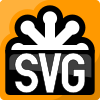

In [11]:
from IPython.display import SVG
def show_svg():
    return SVG("SVG_logo.svg")

show_svg()

In [3]:
# Always remember to close the communication to the robot and have not more than one instances running
r.secmon.close()
r.rtmon.close()
r = None
sleep(2)